In [2]:
%matplotlib inline

import os
import textwrap
import math

import datetime as dt
import pandas as pd

import matplotlib        as mpl
import matplotlib.pyplot as plt

import numpy             as np
import tables            as tb
import seaborn as sns

#import invisible_cities.core.core_functions as coref
#import invisible_cities.core.fit_functions  as fitf

from   scipy.optimize                          import curve_fit
from   scipy                                   import stats

#from   invisible_cities.io.dst_io import df_writer

# Formatting options
pd.options.display.max_columns = None
mpl.rcParams.update({'font.size': 18})
mpl.rcParams['image.cmap'] = 'Greys'
mpl.rcParams['patch.force_edgecolor'] = False
mpl.rcParams['patch.facecolor'] = 'gray'
hargs = {'histtype': 'stepfilled', 'edgecolor': 'black', 'facecolor': 'gray'}

# Directory to which figures will be stored
save_dir = "Trazas"
ftype = "pdf"
if(not os.path.isdir(save_dir)):
    print("Creating directory",save_dir)
    os.mkdir(save_dir)

In [3]:
evtfnames_data = ["/Users/diego/Desktop/DIEGO/USC/TFG/data/ntuple_combined_7746.h5"]
evtfnames_MC   = ["/Users/diego/Dropbox/NEXT/ntuple_combined_MC_6206.h5",
              "/Users/diego/Dropbox/NEXT/ntuple_combined_MC_6207.h5",
              "/Users/diego/Dropbox/NEXT/ntuple_combined_MC_6208.h5",]

In [4]:
cdf = None
for ifile,fname in enumerate(evtfnames_MC):

    print("Adding file {} ...".format(fname))

    ftbl = tb.open_file(fname, 'r')
    
    fsummary = ftbl.root.Summary.Events
    fdst = ftbl.root.DST.Events
    ftracks = ftbl.root.Tracking.Tracks

    # Read the tables into DataFrames.
    to_df = pd.DataFrame.from_records
    df_summary = to_df(fsummary.read())
    df_tracks = to_df(ftracks.read())
    df_dst = to_df(fdst.read())
    
    # Drop duplicates in the KDST, selecting the S1 and S2 with highest energy.
    df_dst1 = df_dst.sort_values(['event','S1e','S2e'])[['event','S2e','S1e','nS1','nS2']].drop_duplicates('event',keep='last')
    
    # Drop duplicates in the TDST, selecting the longest tracks.
    # df_tracks = df_tracks.sort_values(['event','length','energy']).drop_duplicates('event',keep='last')
    # Agora non queremos seleccionar a traza máis longa de cada evento, queremos analizalas todas
    
    # Merge into a single dataframe.
    df_merge = pd.merge(df_summary, df_dst1, on = 'event', how='left')
    df_merge = pd.merge(df_merge, df_tracks, on = 'event', how='left')
    
    # Concatenate with previous runs.
    if(cdf is None):
        cdf = df_merge
    else:
        cdf = cdf.append(df_merge)
        
    ftbl.close()

A_evtnum    = cdf['event'].values
A_maxtrklen = cdf['length'].values
A_maxtrkenergy = cdf['energy'].values
A_ntrks     = cdf['evt_ntrks'].values
A_nhits     = cdf['evt_nhits'].values
A_Ec        = cdf['evt_energy'].values
A_xavg      = cdf['evt_x_avg'].values
A_yavg      = cdf['evt_y_avg'].values
A_zavg      = cdf['evt_z_avg'].values
A_ravg      = cdf['evt_r_avg'].values
A_xmin      = cdf['evt_x_min'].values
A_ymin      = cdf['evt_y_min'].values
A_zmin      = cdf['evt_z_min'].values
A_xmax      = cdf['evt_x_max'].values
A_ymax      = cdf['evt_y_max'].values
A_zmax      = cdf['evt_z_max'].values
A_rmin      = cdf['evt_r_min'].values
A_rmax      = cdf['evt_r_max'].values
A_nS1       = cdf['nS1'].values
A_S2e       = cdf['S2e'].values

print("{} total events".format(len(A_evtnum)))

Adding file /Users/diego/Dropbox/NEXT/ntuple_combined_MC_6206.h5 ...
Adding file /Users/diego/Dropbox/NEXT/ntuple_combined_MC_6207.h5 ...
Adding file /Users/diego/Dropbox/NEXT/ntuple_combined_MC_6208.h5 ...
509254 total events


In [5]:
justone_nS = cdf[(cdf.nS1 == 1) & (cdf.nS2 == 1)]

justone_nS.head(10)

,event,evt_energy,evt_charge,evt_ntrks,evt_nhits,evt_x_avg,evt_y_avg,evt_z_avg,evt_r_avg,evt_x_min,evt_y_min,evt_z_min,evt_r_min,evt_x_max,evt_y_max,evt_z_max,evt_r_max,evt_out_of_map,S2e,S1e,nS1,nS2,trackID,energy,length,numb_of_voxels,numb_of_hits,numb_of_tracks,x_min,y_min,z_min,r_min,x_max,y_max,z_max,r_max,x_ave,y_ave,z_ave,r_ave,extreme1_x,extreme1_y,extreme1_z,extreme2_x,extreme2_y,extreme2_z,blob1_x,blob1_y,blob1_z,blob2_x,blob2_y,blob2_z,eblob1,eblob2,ovlp_blob_energy,vox_size_x,vox_size_y,vox_size_z
0,1,1.491183,-1.0,1,153,-113.623835,45.844995,198.700846,123.571428,-155.0,15.0,177.125250,79.056942,-75.0,95.0,208.673156,168.077363,False,399937.37500,490.154266,1,1,0,1.491183,110.245795,58,153,1,-155.0,15.0,177.125250,79.056942,-75.0,95.0,208.673156,168.077363,-113.623835,45.844995,198.700846,123.571428,-1.100000e+02,9.000000e+01,177.899203,-8.000000e+01,3.000000e+01,207.899203,-75.000000,25.000000,206.110672,-105.0,95.0,178.439502,0.304461,0.105867,0.00000,10.0,10.0,10.0
3,3,1.454100,-1.0,2,167,17.380662,24.086533,271.829615,32.352240,-5.0,-15.0,251.202844,7.071068,35.0,165.0,296.603531,165.075740,False,409170.59375,510.470215,1,1,0,1.448270,109.746915,37,165,2,-5.0,-15.0,251.202844,7.071068,35.0,85.0,296.603531,88.600226,17.476393,23.533727,271.841606,31.805387,1.000000e+01,-1.000000e+01,253.903187,2.000000e+01,8.000000e+01,293.903188,5.000000,-15.000000,254.855618,25.0,85.0,289.735796,0.193550,0.096244,0.00000,10.0,10.0,10.0
4,3,1.454100,-1.0,2,167,17.380662,24.086533,271.829615,32.352240,-5.0,-15.0,251.202844,7.071068,35.0,165.0,296.603531,165.075740,False,409170.59375,510.470215,1,1,1,0.005830,0.000000,1,1,2,-5.0,165.0,268.850625,165.075740,-5.0,165.0,268.850625,165.075740,-5.000000,165.000000,268.850625,165.075740,-2.250644e-12,1.600000e+02,263.903187,-2.250644e-12,1.600000e+02,263.903187,-5.000000,165.000000,268.850625,-5.0,165.0,268.850625,0.005830,0.005830,0.00583,10.0,10.0,10.0
7,5,1.499156,-1.0,1,135,-142.819879,5.633705,190.563333,143.303047,-165.0,-25.0,180.146500,115.974135,-115.0,25.0,207.875656,165.680415,False,394655.78125,425.728394,1,1,0,1.499156,44.142136,25,132,1,-165.0,-15.0,180.146500,115.974135,-115.0,25.0,207.875656,165.075740,-142.804813,5.664735,190.554229,143.284756,-1.600000e+02,-1.776357e-15,184.011078,-1.200000e+02,1.000000e+01,184.011078,-165.000000,-2.641590,182.475908,-115.0,15.0,187.356353,0.380602,0.233692,0.00000,10.0,10.0,10.0
8,6,1.521329,-1.0,1,136,-87.650980,150.675900,295.752377,175.009691,-115.0,135.0,267.101812,149.833241,-45.0,175.0,332.806750,195.576072,False,315667.71875,624.252686,1,1,0,1.521329,87.067423,39,135,1,-115.0,135.0,267.101812,149.833241,-55.0,175.0,332.806750,195.576072,-87.686408,150.675900,295.752377,175.019961,-1.100000e+02,1.500000e+02,269.954281,-6.000000e+01,1.700000e+02,329.954281,-115.000000,145.000000,271.247362,-55.0,175.0,332.427351,0.398977,0.128317,0.00000,10.0,10.0,10.0
9,7,1.689332,-1.0,1,164,-32.128175,14.058594,148.289215,40.096504,-55.0,-15.0,118.136500,15.811388,-5.0,65.0,203.705312,79.056942,False,501236.40625,447.781403,1,1,0,1.689332,127.566304,46,163,1,-55.0,-15.0,118.136500,15.811388,-5.0,65.0,203.705312,79.056942,-32.092280,14.058594,148.289215,40.072389,-4.000000e+01,-1.000000e+01,140.920906,-4.000000e+01,6.000000e+01,200.920906,-45.000000,-15.000000,140.745268,-45.0,65.0,202.884699,0.440450,0.132779,0.00000,10.0,10.0,10.0
10,8,1.445031,-1.0,1,123,-87.123203,-3.437025,422.807476,87.674872,-105.0,-25.0,406.162781,65.192024,-65.0,25.0,443.704250,106.066017,False,369270.28125,625.633728,1,1,0,1.445031,45.604779,25,120,1,-105.0,-25.0,406.162781,65.192024,-65.0,15.0,443.704250,106.066017,-87.123203,-3.463015,422.818045,87.668929,-8.000000e+01,-1.000000e+01,439.933516,-7.000000e+01,-1.776357e-15,409.933516,-65.000000,-1.418004,413.958844,-85.0,-15.0,440.780239,0.434134,0.297586,0.00000,10.0,10.0,10.0
11,9,1.611417,-1.0,1,142,22.460123,-159.868696,156.901870,161.728800,-5.0,-185.0,124.172078,135.092561,45.0,-135.0,187.634000,188.281704,Fals

# Distribución Enerxética das Trazas

Text(0, 0.5, 'Counts')

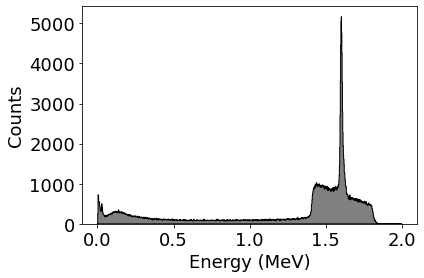

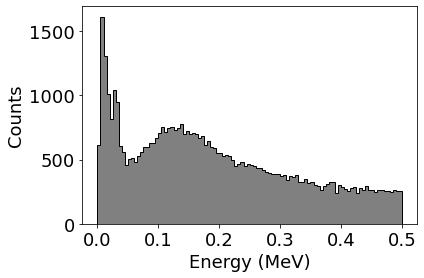

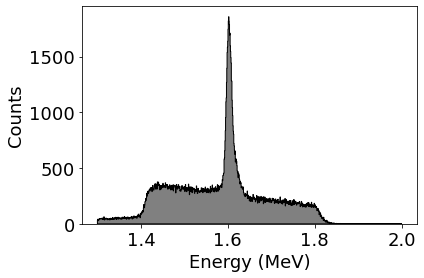

In [6]:
plt.figure(1)

x, y, _ = plt.hist(justone_nS.energy, 1000, range=[0.0,2.0], **hargs)
#plt.yscale('log')
plt.xlabel('Energy (MeV)')
plt.ylabel('Counts')


plt.figure(2)

x, y, _ = plt.hist(justone_nS.energy, 100, range=[0.0,0.5], **hargs)
#plt.yscale('log')
plt.xlabel('Energy (MeV)')
plt.ylabel('Counts')


plt.figure(3)

x, y, _ = plt.hist(justone_nS.energy, 1000, range=[1.3,2.0], **hargs)
#plt.yscale('log')
plt.xlabel('Energy (MeV)')
plt.ylabel('Counts')

# Lonxitude en X, Y e Z

Text(0, 0.5, 'Counts')

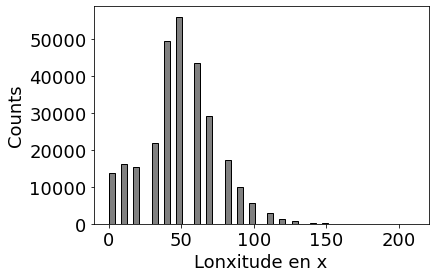

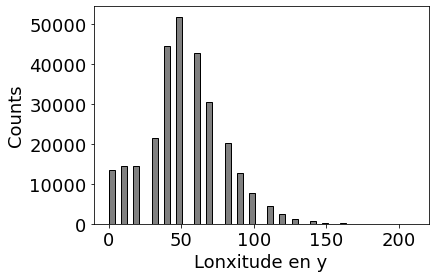

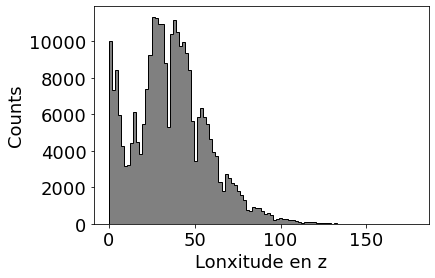

In [7]:
lonxitude_total_x = justone_nS.x_max - justone_nS.x_min
lonxitude_total_y = justone_nS.y_max - justone_nS.y_min
lonxitude_total_z = justone_nS.z_max - justone_nS.z_min

plt.figure(1)

x, y, _ = plt.hist(lonxitude_total_x, 50, **hargs)
#plt.yscale('log')
plt.xlabel('Lonxitude en x')
plt.ylabel('Counts')

plt.figure(2)

x, y, _ = plt.hist(lonxitude_total_y, 50, **hargs)
#plt.yscale('log')
plt.xlabel('Lonxitude en y')
plt.ylabel('Counts')

plt.figure(3)

x, y, _ = plt.hist(lonxitude_total_z, 100, **hargs)
#plt.yscale('log')
plt.xlabel('Lonxitude en z')
plt.ylabel('Counts')

# Lonxitude Total

As primeiras 11172.0 trazas teñen lonxitude 0.0
A traza máis longa mide 274.3806415196851, e hai 1.0 trazas desa lonxitude


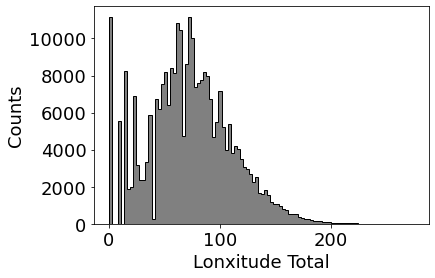

In [8]:
x, y, _ = plt.hist(justone_nS.length, 100, **hargs)
#plt.yscale('log')
plt.xlabel('Lonxitude Total')
plt.ylabel('Counts')
#print('Hai {} trazas de lonxitude ~ 0 m'.format(x[0]))
print('As primeiras {} trazas teñen lonxitude {}'.format(x[0], y[0]))
print('A traza máis longa mide {}, e hai {} trazas desa lonxitude'.format(y[-1], x[-1]))

Text(0.5, 0, 'Enerxía')

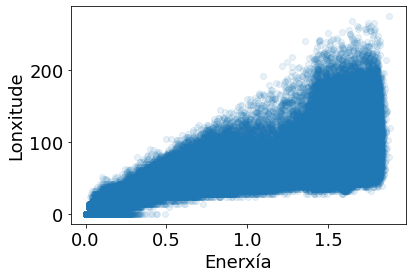

In [9]:
plt.figure(1)

plt.scatter(justone_nS.energy, justone_nS.length, alpha=0.1)
plt.ylabel('Lonxitude')
plt.xlabel('Enerxía')

#HAI UN MONTÓN DE PUNTOS CON LONXITUDE 0 E ENERXÍA QUE VARÍA ENTRE 0 E 0.5 MeV.
#NECESITA UN PROFILE

In [50]:
l0

,event,evt_energy,evt_charge,evt_ntrks,evt_nhits,evt_x_avg,evt_y_avg,evt_z_avg,evt_r_avg,evt_x_min,evt_y_min,evt_z_min,evt_r_min,evt_x_max,evt_y_max,evt_z_max,evt_r_max,evt_out_of_map,S2e,S1e,nS1,nS2,trackID,energy,length,numb_of_voxels,numb_of_hits,numb_of_tracks,x_min,y_min,z_min,r_min,x_max,y_max,z_max,r_max,x_ave,y_ave,z_ave,r_ave,extreme1_x,extreme1_y,extreme1_z,extreme2_x,extreme2_y,extreme2_z,blob1_x,blob1_y,blob1_z,blob2_x,blob2_y,blob2_z,eblob1,eblob2,ovlp_blob_energy,vox_size_x,vox_size_y,vox_size_z
4,3,1.454100,-1.0,2,167,17.380662,24.086533,271.829615,32.352240,-5.0,-15.0,251.202844,7.071068,35.0,165.0,296.603531,165.075740,False,409170.59375,510.470215,1,1,1,0.005830,0.0,1,1,2,-5.0,165.0,268.850625,165.075740,-5.0,165.0,268.850625,165.075740,-5.0,165.000000,268.850625,165.075740,-2.250644e-12,160.0,263.903187,-2.250644e-12,160.0,263.903187,-5.0,165.000000,268.850625,-5.0,165.000000,268.850625,0.005830,0.005830,0.005830,10.0,10.0,10.0
48,35,1.663346,-1.0,2,159,-44.401042,10.558623,321.018226,47.780695,-65.0,-35.0,304.988094,25.495098,-25.0,55.0,344.789656,79.056942,False,457247.56250,695.938171,1,1,1,0.006460,0.0,1,1,2,-25.0,-35.0,322.892031,43.011626,-25.0,-35.0,322.892031,43.011626,-25.0,-35.000000,322.892031,43.011626,-3.000000e+01,-30.0,319.888875,-3.000000e+01,-30.0,319.888875,-25.0,-35.000000,322.892031,-25.0,-35.000000,322.892031,0.006460,0.006460,0.006460,10.0,10.0,10.0
117,76,1.786148,-1.0,3,177,8.776492,143.641545,266.568360,144.753572,-45.0,105.0,243.138625,107.935166,35.0,195.0,292.683312,195.064092,False,431478.28125,647.580811,1,1,2,0.014719,0.0,1,1,3,-35.0,135.0,243.138625,139.463257,-35.0,135.0,243.138625,139.463257,-35.0,135.000000,243.138625,139.463257,-3.000000e+01,140.0,247.910969,-3.000000e+01,140.0,247.910969,-35.0,135.000000,243.138625,-35.0,135.000000,243.138625,0.014719,0.014719,0.014719,10.0,10.0,10.0
148,96,NaN,-1.0,2,153,NaN,NaN,NaN,NaN,25.0,-185.0,204.001063,159.530561,105.0,-135.0,241.752344,207.966343,True,330389.37500,550.870850,1,1,1,0.021214,0.0,1,1,2,35.0,-185.0,229.903844,188.281704,35.0,-185.0,229.903844,188.281704,35.0,-185.000000,229.903844,188.281704,4.000000e+01,-180.0,227.876703,4.000000e+01,-180.0,227.876703,35.0,-185.000000,229.903844,35.0,-185.000000,229.903844,0.021214,0.021214,0.021214,10.0,10.0,10.0
214,137,1.601295,-1.0,2,162,37.992906,-94.757293,260.444768,102.495207,5.0,-125.0,236.188187,65.192024,55.0,-65.0,297.747437,132.853303,False,432753.96875,598.715820,1,1,1,0.004618,0.0,1,1,2,5.0,-65.0,295.943469,65.192024,5.0,-65.0,295.943469,65.192024,5.0,-65.000000,295.943469,65.192024,1.000000e+01,-70.0,296.967813,1.000000e+01,-70.0,296.967813,5.0,-65.000000,295.943469,5.0,-65.000000,295.943469,0.004618,0.004618,0.004618,10.0,10.0,10.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
353285,798000856,NaN,-1.0,2,160,NaN,NaN,NaN,NaN,-35.0,145.0,231.163781,145.773797,35.0,205.0,276.764969,206.518764,True,298638.59375,599.510254,1,1,1,0.009794,0.0,1,1,2,-15.0,145.0,250.836344,145.773797,-15.0,145.0,250.836344,145.773797,-15.0,145.000000,250.836344,145.773797,-1.000000e+01,150.0,253.964375,-1.000000e+01,150.0,253.964375,-15.0,145.000000,250.836344,-15.0,145.000000,250.836344,0.009794,0.009794,0.009794,10.0,10.0,10.0
353327,798000886,1.613468,-1.0,2,141,-10.370320,26.781925,509.682450,38.390378,-45.0,-25.0,496.014875,15.811388,25.0,95.0,521.718375,98.234414,False,410088.43750,726.698914,1,1,1,0.020304,0.0,1,1,2,15.0,95.0,505.882375,96.176920,15.0,95.0,505.882375,96.176920,15.0,95.000000,505.882375,96.176920,1.000000e+01,90.0,508.866625,1.000000e+01,90.0,508.866625,15.0,95.000000,505.882375,15.0,95.000000,505.882375,0.020304,0.020304,0.020304,10.0,10.0,10.0
353329,798000887,1.752385,-1.0,2,165,-137.856973,32.581161,199.046020,142.066457,-155.0,15.0,184.082344,117.686023,-115.0,85.0,209.638531,

# Análise Trazas de Lonxitude = 0

INFORMACIÓN XENERAL SOBRE l0x
DescribeResult(nobs=11172, minmax=(0.0, 10.0), mean=0.37056928034371645, variance=3.568690643575062, skewness=4.901427367183976, kurtosis=22.02399023578005)

CONTAS
0 u: 96.294%; 1 u: 0.000%; 2 u: 0.000%; 3 u: 0.000%; 4 u: 0.000%; 5 u: 0.000%; 6 u: 0.000%; 7 u: 0.000000%; 8 u: 0.000000%; 9 u: 0.000%; 10 u: 3.706%



INFORMACIÓN XENERAL SOBRE l0z
DescribeResult(nobs=11172, minmax=(0.0, 9.940406250000024), mean=0.8227523251488096, variance=2.055758001252499, skewness=2.183203855940377, kurtosis=5.731195213987197)

CONTAS
0 u: 68.009%; 1 u: 0.403%; 2 u: 23.684%; 3 u: 0.116%; 4 u: 5.317%; 5 u: 0.000%; 6 u: 1.835%; 7 u: 0.000%; 8 u: 0.563910%; 9 u: 0.000000%; 9.94 u: 0.072%



INFORMACIÓN XENERAL SOBRE l0y
DescribeResult(nobs=11172, minmax=(0.0, 10.0), mean=0.34550662370211244, variance=3.335990012757124, skewness=5.096939504527583, kurtosis=23.97879231281388)

CONTAS
0 u: 96.545%; 1 u: 0.000%; 2 u: 0.000%; 3 u: 0.000%; 4 u: 0.000%; 5 u: 0.000%; 6 u: 0.000%;7 u

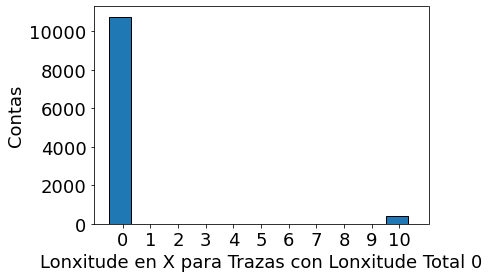

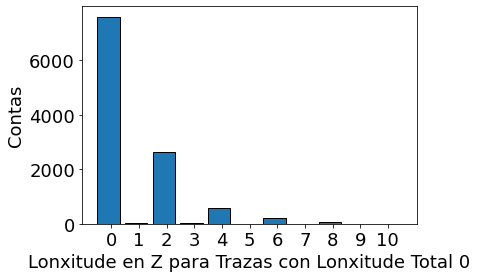

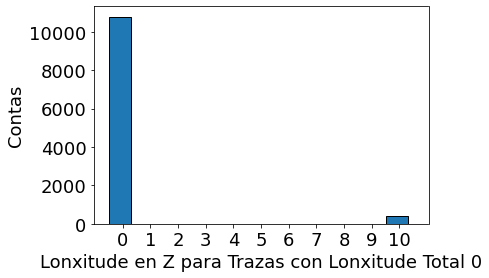

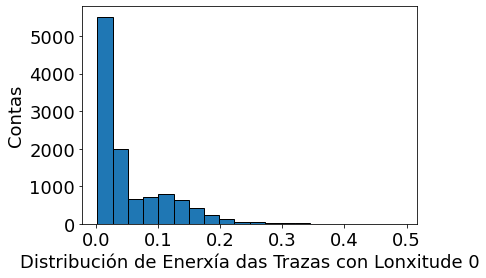

In [71]:
l0 = justone_nS[(justone_nS.length == 0)]


l0x = l0.x_max - l0.x_min
l0y = l0.y_max - l0.y_min
l0z = l0.z_max - l0.z_min


plt.figure(1)

bins = np.arange(start=0, stop=12) - 0.5
n, bins, patches = plt.hist(l0x, bins, edgecolor='black', width=0.8)
plt.xticks(np.arange(start=0, stop=11))
plt.xlabel('Lonxitude en X para Trazas con Lonxitude Total 0')
plt.ylabel('Contas')

#CREO LOS PORCENTAJES
x = stats.describe(l0x)
a = []
for i in range(len(n)):
    a.append((n[i]/x[0])*100)
    
print('INFORMACIÓN XENERAL SOBRE l0x')
print(x)
print('')
print('CONTAS')
print('0 u: {:.3f}%; 1 u: {:.3f}%; 2 u: {:.3f}%; 3 u: {:.3f}%; 4 u: {:.3f}%;'
      ' 5 u: {:.3f}%; 6 u: {:.3f}%; 7 u: {:.6f}%; 8 u: {:.6f}%; 9 u: {:.3f}%; 10 u: {:.3f}%'.format(a[0],a[1],
                                                                                                a[2],a[3],a[4],
                                                                                    a[5],a[6],a[7],a[8],a[9],a[10]))
print('\n\n')


plt.figure(2)

bins = np.arange(start=0, stop=12) - 0.5
n, bins, patches = plt.hist(l0z, bins, edgecolor='black', width=0.8)
plt.xticks(np.arange(start=0, stop=11))
plt.xlabel('Lonxitude en Z para Trazas con Lonxitude Total 0')
plt.ylabel('Contas')

#CREO LOS PORCENTAJES
z = stats.describe(l0z)
b = []
for i in range(len(n)):
    b.append((n[i]/z[0])*100)
    
print('INFORMACIÓN XENERAL SOBRE l0z')
print(z)
print('')
print('CONTAS')
print('0 u: {:.3f}%; 1 u: {:.3f}%; 2 u: {:.3f}%; 3 u: {:.3f}%; 4 u: {:.3f}%; 5 u: {:.3f}%;'
      ' 6 u: {:.3f}%; 7 u: {:.3f}%; 8 u: {:.6f}%; 9 u: {:.6f}%; 9.94 u: {:.3f}%'.format(b[0],b[1],b[2],b[3],b[4],
                                                                                    b[5],b[6],b[7],b[8],b[9],b[10]))
print('\n\n')

plt.figure(3)

bins = np.arange(start=0, stop=12) - 0.5
n, bins, patches = plt.hist(l0y, bins, edgecolor='black', width=0.8)
plt.xticks(np.arange(start=0, stop=11))
plt.xlabel('Lonxitude en Z para Trazas con Lonxitude Total 0')
plt.ylabel('Contas')

#CREO LOS PORCENTAJES
y = stats.describe(l0y)
c = []
for i in range(len(n)):
    c.append((n[i]/y[0])*100)
    
print('INFORMACIÓN XENERAL SOBRE l0y')
print(y)
print('')
print('CONTAS')
print('0 u: {:.3f}%; 1 u: {:.3f}%; 2 u: {:.3f}%; 3 u: {:.3f}%; 4 u: {:.3f}%; 5 u: {:.3f}%; 6 u: {:.3f}%;'
      '7 u: {:.3f}%; 8 u: {:.6f}%; 9 u: {:.6f}%; 10 u: {:.3f}%'.format(c[0],c[1],c[2],c[3],c[4],c[5],c[6],
                                                                       c[7],c[8],c[9],c[10]))



plt.figure(4)

#bins = np.arange(start=0, stop=0.5) - 0.5
n, bins, patches = plt.hist(l0.energy, bins=20, edgecolor='black')
#plt.xticks(np.arange(start=0, stop=11))
plt.xlabel('Distribución de Enerxía das Trazas con Lonxitude 0')
plt.ylabel('Contas')

print('\n\n')
print('INFORMACIÓN SOBRE A DISTRIBUCIÓN ENERXÉTICA DAS TRAZAS CON LONXITUDE TOTAL 0')
print(stats.describe(l0.energy))

In [70]:
print(c)

[]
